In [31]:
import json
import subprocess
import sys

def ensure_package(import_name: str, install_name: str | None = None) -> None:
    """Install a pip package if missing (best-effort)."""
    install_name = install_name or import_name
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'list', '--format=json'],
        check=True,
        capture_output=True,
        text=True,
    )
    installed = {pkg['name'].lower() for pkg in json.loads(result.stdout)}
    # Some packages have different import vs distribution names (e.g., rdkit-pypi -> rdkit)
    if import_name.lower() in installed or (install_name and install_name.lower() in installed):
        print(f'{import_name} already installed.')
        return
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', install_name])
    print(f'Installed {install_name} (import as {import_name}).')

for pkg in [
    ('numpy', None),
    ('pandas', None),
    ('matplotlib', None),
    ('joblib', None),
    # rdkit wheels are commonly available as rdkit-pypi (import name is rdkit)
    ('rdkit', 'rdkit'),
    ('scikit-learn', ),
    ('sklearn-genetic-opt', None),
]:
    ensure_package(*pkg)

numpy already installed.
pandas already installed.
matplotlib already installed.
joblib already installed.
rdkit already installed.
scikit-learn already installed.
sklearn-genetic-opt already installed.


In [43]:
from pathlib import Path
OUTPUT_DIR = Path('results/eda-GA')
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [63]:
import json
from pathlib import Path
import joblib
def save_results(timestamp: str = '', params: dict = None, best_iteration: int = None, valid_score: float = None, additional_score: dict = None, name: str = '', feature_list: list = None) -> None:
    results = {
        'model_params': params,
        'best_iteration': best_iteration,
        'valid_score': valid_score,
        'additional_score': additional_score or {},
        'Feature_list': feature_list or [],
    }
    if timestamp:
        results['timestamp'] = timestamp
    results_path = OUTPUT_DIR / f'{name}_results{("_" + timestamp) if timestamp else "_unknown"}.json'
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)


def save_model(timestamp: str = '', model: object = None, name: str = '') -> None:
    model_path = OUTPUT_DIR / f'{name}{("_" + timestamp) if timestamp else "_unknown"}.joblib'
    import joblib
    joblib.dump(model, model_path)


def create_timestamp() -> str:
    from datetime import datetime
    return datetime.now().strftime('%Y%m%d_%H%M%S')

In [34]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [35]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109


In [36]:
import warnings
import joblib
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution
from lightgbm import LGBMRegressor
import time

start = time.time()

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)
# scoring = mean absolute error
ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_mean_absolute_error",
    population_size=100,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=-1,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))



--- 🧬 START RUN GENETIC ALGORITHM ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-135.998	1.37421    	-133.73    	-140.376   
1  	112   	-134.901	0.792213   	-132.184   	-136.637   
2  	106   	-134.324	0.661567   	-132.184   	-136.057   
3  	89    	-133.77 	0.679211   	-132.184   	-135.487   
4  	106   	-133.312	0.568196   	-132.184   	-134.538   
5  	93    	-133.036	0.47586    	-132.184   	-135.073   
6  	94    	-132.794	0.391661   	-131.847   	-134.398   
7  	100   	-132.579	0.339981   	-131.847   	-134.086   
8  	112   	-132.412	0.25665    	-131.847   	-133.233   
9  	100   	-132.274	0.336337   	-131.431   	-134.623   
10 	102   	-132.171	0.410766   	-131.431   	-134.758   
11 	100   	-132.012	0.270691   	-131.339   	-133.614   
12 	95    	-131.91 	0.140587   	-131.431   	-132.184   
13 	107   	-131.873	0.0965783  	-131.431   	-132.301   
14 	94    	-131.855	0.169595   	-131.431   	-133.424   
15 	93    	-131.827	0.0637682  	-131.431   	-131.847   
16 	95   

In [48]:

# Save results and model
timestamp = create_timestamp()


In [54]:
print(ga.get_params())

{'algorithm': 'eaMuPlusLambda', 'criteria': 'max', 'crossover_probability': 0.2, 'cv': 3, 'elitism': True, 'error_score': nan, 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': 1, 'estimator__num_leaves': 31, 'estimator__objective': None, 'estimator__random_state': None, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator__verbose': -1, 'estimator': LGBMRegressor(n_jobs=1, verbose=-1), 'generations': 20, 'keep_top_k': 1, 'log_config': None, 'max_features': None, 'mutation_probability': 0.3, 'n_jobs': -1, 'population_size': 100, 'pre_dispatch': '2*n_jobs', 're

In [64]:

save_results(
    timestamp=timestamp,
    params=None,
    best_iteration=None,
    valid_score=None,
    additional_score={},
    name='GAFeatureSelectionCV',
    feature_list=list(selected_ga)
)





Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 480 features: R2 = 0.6020 | RMSE = 265.64
   -> Dùng 430 features: R2 = 0.6004 | RMSE = 266.16
   -> Dùng 380 features: R2 = 0.5970 | RMSE = 267.28
   -> Dùng 330 features: R2 = 0.5957 | RMSE = 267.74
   -> Dùng 280 features: R2 = 0.5981 | RMSE = 266.94
   -> Dùng 230 features: R2 = 0.6026 | RMSE = 265.44
   -> Dùng 180 features: R2 = 0.5978 | RMSE = 267.02
   -> Dùng 130 features: R2 = 0.5959 | RMSE = 267.67
   -> Dùng  90 features: R2 = 0.5968 | RMSE = 267.35
   -> Dùng  80 features: R2 = 0.5892 | RMSE = 269.88
   -> Dùng  70 features: R2 = 0.5890 | RMSE = 269.92
   -> Dùng  60 features: R2 = 0.5722 | RMSE = 275.41
   -> Dùng  50 features: R2 = 0.5746 | RMSE = 274.62
   -> Dùng  40 features: R2 = 0.5541 | RMSE = 281.16
   -> Dùng  30 features: R2 = 0.5772 | RMSE = 273.78
   -> Dùng  20 features: R2 = 0.5759 | RMSE = 274.20
   -> Dùng  10 features: R2 = 0.5691 | RMSE = 276.39


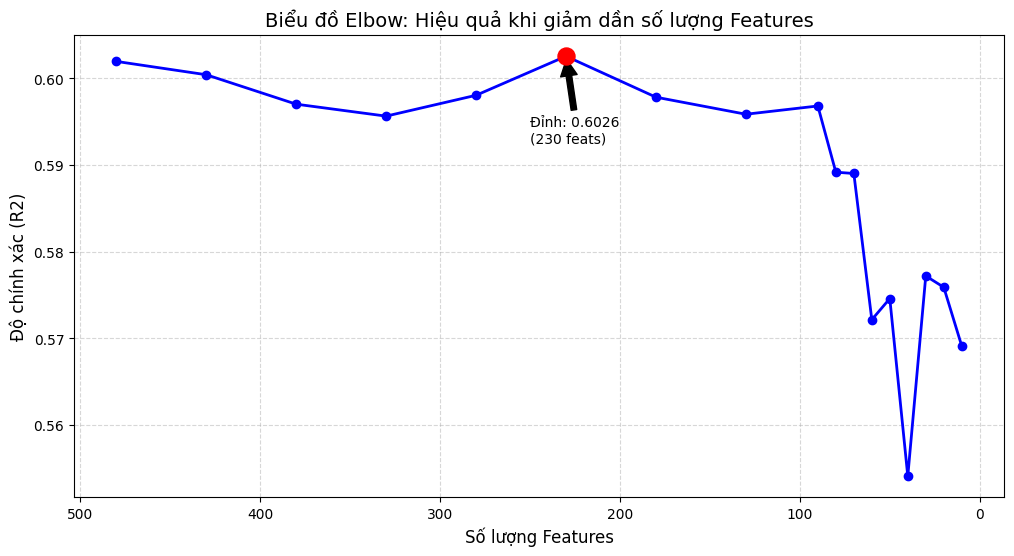


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.602567           230  265.443151
1  0.601969           480  265.642664
2  0.600430           430  266.155776
3  0.598059           280  266.944294
4  0.597841           180  267.016895
5  0.597033           380  267.284869
6  0.596825            90  267.353949
7  0.595872           130  267.669707
8  0.595653           330  267.742049
9  0.589183            80  269.875604

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.569121  276.386694
15            20  0.575904  274.202732
14            30  0.577210  273.780205
13            40  0.554096  281.164241
12            50  0.574603  274.622928
11            60  0.572158  275.410997
10            70  0.589035  269.924353
9             80  0.589183  269.875604
8             90  0.596825  267.353949
7            130  0.595872  267.669707


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))